In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from functools import partial
# from funcy import compose
compose = lambda *F: reduce(lambda f, g: lambda x: f(g(x)), F)
import numpy as np
from parametric_pde_find import *
from robust_pde_diff import DLrSR, RobustPCA
from scipy.integrate import odeint
from scipy.signal import savgol_filter, periodogram
from scipy.stats import wilcoxon, ranksums, mannwhitneyu, friedmanchisquare
from numpy.fft import fft, ifft, fftfreq

from best_subset import *
from solvel0 import solvel0
from UBIC import fit_blr, UBIC, decreasing_values_indices
from para_UBIC import *

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.random import sample_without_replacement
# https://github.com/Pongpisit-Thanasutives/OKRidge
from okridge.solvel0 import okridge_solvel0, okridge_solvel0_full
from findiff import FinDiff

import sys; sys.path.append('/Users/pongpisit/Documents/github/ICOMP/')
from icomp_lm import *

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from pysr import PySRRegressor

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

def ssr2llf(ssr, nobs, epsilon=1e-5):
    nobs2 = nobs / 2.0
    # llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    llf = -nobs2*np.log(2*np.pi*ssr/nobs+epsilon)
    return llf

def rss2bic(rss, nparams, nobs, epsilon=1e-5):
    # llf = ssr2llf(rss, nobs, epsilon)
    # return -2*llf + np.log(nobs)*nparams
    return nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*nparams

def BIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # BIC
    res = np.vstack([bs[j] - As[j]@x[:, j:j+1] for j in range(m)])
    assert len(res) == n*m
    rss = np.linalg.norm(res, ord='fro')**2 
    # llf = -(N/2)*np.log(2*np.pi*rss/N+epsilon)
    # -2*llf + np.log(N)*k # AIC: -2*llf + 2*k
    # return -2*llf + np.log(N)*k
    return N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k

np.random.seed(1234)
fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
Best-subset solvers are NOT installed.
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
def advection_rhs(u, t, params):
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))
    return real(deriv)

def spatial_temporal_group(Theta, Ut, domain_shape, dependent="temporal"):
    n, m = domain_shape
    assert n*m == Theta.shape[0], Ut.shape[0]
    if dependent == "temporal":
        Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
        Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]
    elif dependent == "spatial":
        Theta_grouped = [(Theta[n*np.arange(m)+j,:]).real for j in range(n)]
        Ut_grouped = [(Ut[n*np.arange(m)+j]).real for j in range(n)]
    else: return
    return np.array(Theta_grouped), np.array(Ut_grouped)

def normalize_groups(As, bs, normalize=2):
    m = len(As)
    n,D = As[0].shape
    
    # get norm of each column
    candidate_norms = np.zeros(D)
    for i in range(D):
        candidate_norms[i] = Norm(np.vstack([A[:,i] for A in As]), normalize)

    norm_bs = [m*Norm(b, normalize) for b in bs]

    normalized_As = As.copy()
    normalized_bs = bs.copy()
    # normalize
    for i in range(m):
        normalized_As[i] = normalized_As[i].dot(np.diag(candidate_norms**-1))
        normalized_bs[i] = normalized_bs[i]/norm_bs[i]
        
    return normalized_As, normalized_bs

def remove_f(uu, percent):
    if percent <= 0: return uu
    PSD = (uu*np.conj(uu))/np.prod(uu.shape)
    PSD = PSD.real
    mask = (PSD>np.percentile(PSD, percent)).astype(np.float32)
    return uu*mask

In [3]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

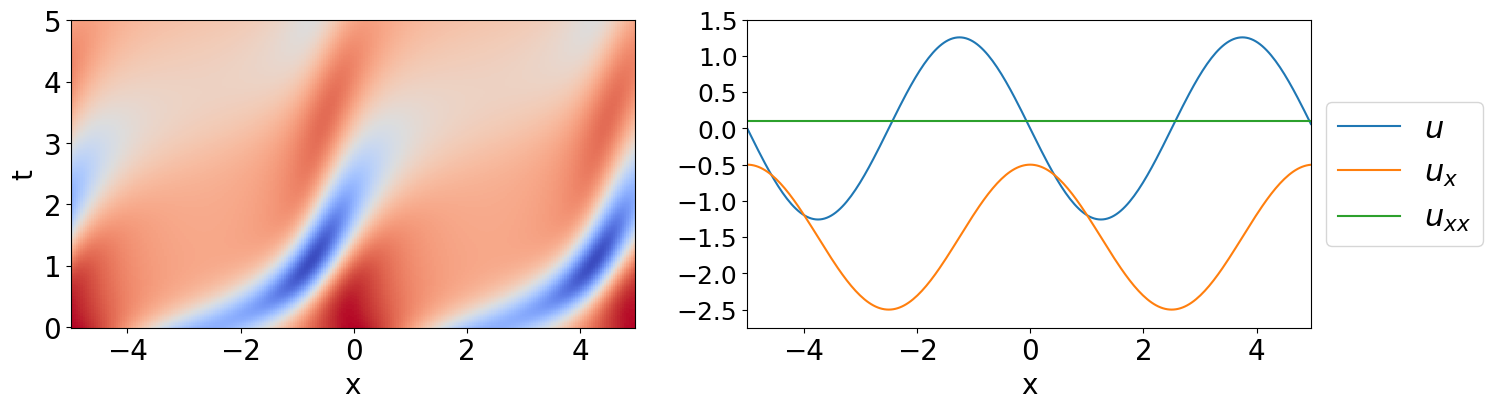

In [4]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
show()
# fig.tight_layout()

In [5]:
noise_lv = 4 # 2, 4
noise_lv = abs(noise_lv)
u_clean = u.copy()
u = u + 0.01*noise_lv*std(u)*np.random.randn(*u.shape)

In [6]:
is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    # equivalent to np.hstack([savgol_filter(u[:, i], window_size, poly_order).reshape(-1, 1) for i in range(u.shape[-1])])
    u = savgol_filter(u, window_size, poly_order, axis=0)

In [7]:
# Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, 
#                                          time_diff = 'FD', space_diff = 'Fourier')
alpha = 3e-4 # 1e-3 (ok for pysr env. but not ok for pysindy_latest env.)
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                        diff_kwargs, 
                                                                        include_bias=False)
# Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n,m), "spatial")

fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(len(rhs_des))])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

# physics is such fundamental that it can be discovered from in low-freq data (validation set)
# fft_percent = 90
# acc = 8
# d_dx = FinDiff(0, dx, 1, acc=acc); u_x = d_dx(u)
# d_dxx = FinDiff(0, dx, 2, acc=acc); u_xx = d_dxx(u)
# d_dxxx = FinDiff(0, dx, 3, acc=acc); u_xxx = d_dxxx(u)
# d_dt = FinDiff(1, dt, 1, acc=acc); u_t = d_dt(u)
    
# phi1 = [u**i for i in range(0, 4)]; phi1_names = ["", "u", "u^{2}", "u^{3}"]
# phi2 = [u_x, u_xx, u_xxx]; phi2_names = ["u_{x}", "u_{xx}", "u_{xxx}"]
# phi = phi1.copy(); phi_names = phi1_names.copy()
# phi.extend([p1*p2 for p1 in phi1 for p2 in phi2])
# phi = np.array(phi)
# phi_names.extend([p1+p2 for p1 in phi1_names for p2 in phi2_names])
# fft_phi = [remove_f(fft(_), fft_percent) for _ in phi]
# fft_u_t = remove_f(fft(u_t), fft_percent)

# Theta_grouped = np.moveaxis(phi, 0, -1)
# Ut_grouped = np.expand_dims(u_t, -1)
# rhs_des = phi_names
# fft_Theta_grouped = np.moveaxis(fft_phi, 0, -1)
# fft_Ut_grouped = np.expand_dims(fft_u_t, -1)

# del phi1, phi2, phi1_names, phi2_names

0 u
3 u_x
4 u_xx
5 u_xxx


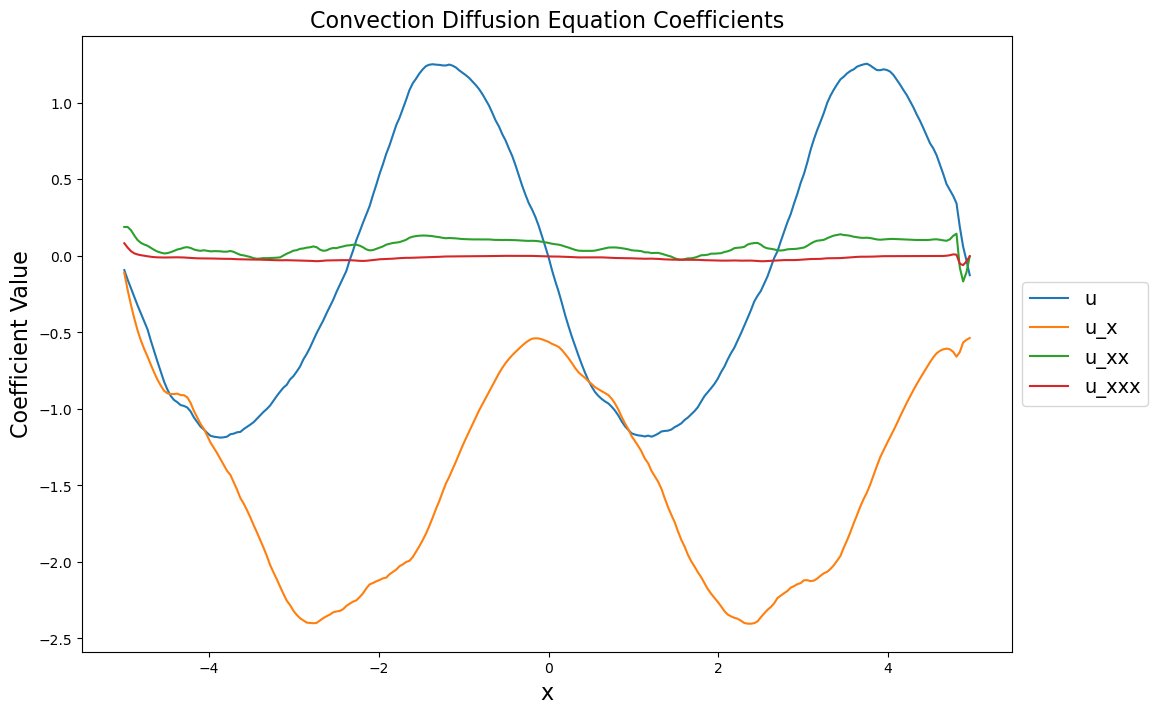

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [9]:
true_xi = np.vstack((u_true, u_x_true, u_xx_true))
errors = xi[[0, 3, 4]]-true_xi
errors = 100*np.linalg.norm(errors, axis=1)/np.linalg.norm(true_xi, axis=1)
errors.mean(), errors.std()

(26.5947279206636, 24.589386673980744)

In [10]:
candidates = {(0, 1, 2, 3, 4, 5, 6, 7, 12, 18),
              (0, 1, 2, 3, 4, 5, 7, 9, 16),
              (0, 1, 3, 4, 5, 6, 7, 14),
              (0, 2, 3, 4, 5, 7, 9),
              (0, 3),
              (0, 3, 4),
              (0, 3, 4, 6),
              (0, 3, 4, 6, 7),
              (0, 3, 4, 6, 7, 13),
              (3,)}
candidates = sorted(candidates, key=len)
rhs_des[0], rhs_des[3], rhs_des[4]

('u', 'u_x', 'u_xx')

In [11]:
f_u, f_u_x, f_u_xx = linear_fit_grouped_data((Theta_grouped, Ut_grouped), considered_indices=candidates[2])

In [12]:
model = PySRRegressor(
    niterations=100,  
    binary_operators=["+", "-", "*"],
    unary_operators=[
        "cos",
        "sin"
    ],
)

In [13]:
# y1 = sin(x * -1.2415)
model.fit(x.reshape(-1,1), f_u.reshape(-1,1))

Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 3.020e+05
Head worker occupation: 20.8%
Progress: 658 / 1500 total iterations (43.867%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           7.493e-01  1.594e+01  y = 0.021894
2           7.439e-01  7.265e-03  y = sin(-0.051785)
3           6.292e-01  1.674e-01  y = 0.11867 * x₀
4           3.478e-02  2.895e+00  y = sin(-1.2415 * x₀)
6           1.347e-02  4.744e-01  y = sin(-1.2497 * x₀) * 1.2075
8           1.057e-02  1.209e-01  y = sin(1.2492 * (0.050533 - x₀)) * 1.2097
10          7.957e-03  1.422e-01  y = (sin(1.2499 * (0.050059 - x₀)) * 1.21) - 0.051172
13          6.644e-03  6.014e-02  y = 1.2097 * sin(((-0.092009 * (cos(x₀) - 0.3664)) - x₀) * 1.2...
                                  492)
14          6.508e-03  2.057e-02  y = 1.2097 * sin(((-0.092009 * (sin(cos(x₀)) - 0.3664)) - x₀) ...
                                  * 1.2492)
1

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                       -0.022327924   
	1         1.163701e-03                                  sin(-0.051785406)   
	2         1.674211e-01                                    0.11866792 * x0   
	3         2.895356e+00                               sin(-1.2415131 * x0)   
	4         4.743989e-01                   sin(-1.2497393 * x0) * 1.2075312   
	5         1.209202e-01     sin(1.2492201 * (0.05053345 - x0)) * 1.2097183   
	6         1.421895e-01  (1.2100059 * sin(0.062589295 - (x0 * 1.2499318...   
	7         6.283551e-08  (1.2100444 * sin((0.050054252 - x0) * 1.249954...   
	8         1.825860e-01  1.2100059 * sin((((cos(x0) + -0.40435097) * -0...   
	9         2.173050e-02  1.2097162 * sin(((-0.092009164 * (sin(cos(x0))...   
	10  >>>>  5.470887e-01  1.2097162 * sin(((-0.092009164 * (cos(x0 * 1.3...   
	11        2.385327e-03  1.2097162 * sin(((-0.092009164 * (cos(x0 * 1.3...   
	12        2.467507e-01  1.2097162 * sin((((cos((x0 + -0.34391642) * -1...   
	13        2.237146e-02  1.2097162 * sin((((cos((x0 + -0.42128354) * -1...   
	14        2.259946e-04  1.2097162 * sin((((cos((x0 + sin(-0.42128354))...   
	15        1.909301e-02  1.2097162 * sin((((cos((x0 + -0.42128354) * -1...   
	
	        loss  complexity  
	0   0.744748           1  
	1   0.743882           2  
	2   0.629208           3  
	3   0.034782           4  
	4   0.013468           6  
	5   0.010575           8  
	6   0.007957          10  
	7   0.007957          12  
	8   0.006629          13  
	9   0.006487          14  
	10  0.003753          15  
	11  0.003745          16  
	12  0.002926          17  
	13  0.002861          18  
	14  0.002860          19  
	15  0.002806          20  
]

In [14]:
# y2 = cos(-1.2439959 * x) - 1.4215299
model.fit(x.reshape(-1,1), f_u_x.reshape(-1,1))

[ Info: Started!



Expressions evaluated per second: 2.790e+05
Head worker occupation: 27.3%
Progress: 580 / 1500 total iterations (38.667%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.508e+00  1.594e+01  y = 0.021894
2           5.814e-01  1.462e+00  y = cos(-3.1416)
3           3.950e-01  3.865e-01  y = -1.0162 * 1.4089
4           2.435e-01  4.839e-01  y = -1.2399 + cos(x₀)
5           2.201e-01  1.009e-01  y = sin(cos(x₀)) + -1.2612
6           1.232e-02  2.882e+00  y = -1.4216 + cos(x₀ * 1.244)
7           6.324e-03  6.673e-01  y = -1.4278 + sin(cos(-1.2508 * x₀))
8           5.804e-03  8.578e-02  y = (cos(-1.2518 * x₀) * 0.88396) - 1.4283
10          5.804e-03  8.941e-08  y = 0.88396 * ((cos(-1.2518 * x₀) + -1.7322) + 0.11644)
11          5.697e-03  1.862e-02  y = (-1.3217 + sin(cos(x₀ * -1.2538) - 0.12173)) * 1.01
13          5.352e-03  3.118e-02  y = (cos(0.18698 * x₀) * 

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        -0.37742636   
	1         0.952176                                     cos(-3.141582)   
	2         0.386524                            -1.3796866 + -0.0520036   
	3         0.483935                               -1.2399416 + cos(x0)   
	4         0.100944                          sin(cos(x0)) + -1.2612419   
	5         2.882430                   -1.4215776 + cos(x0 * 1.2440225)   
	6   >>>>  0.667254             -1.4277629 + sin(cos(-1.2507546 * x0))   
	7         0.085780    (cos(-1.2518202 * x0) * 0.88396406) - 1.4283113   
	8         0.014268  -1.3208313 + sin(cos(x0 * -1.255338) - 0.14381...   
	9         0.002175  (-1.3217324 + sin(cos(x0 * -1.2537719) - 0.121...   
	10        0.007474  -1.3055384 + (sin(cos(-1.2544146 * x0) - sin(0...   
	11        0.054876  (cos(0.18697584 * x0) * (-1.5254406 + cos(1.17...   
	12        0.007778  (cos(x0 * 0.17887527) * (cos(x0 * 1.1803079) +...   
	13        0.015493  ((-1.4660609 + cos(1.1820121 * x0)) * cos(0.17...   
	14        0.000023  ((-1.4660609 + cos(1.1820121 * x0)) * cos(0.17...   
	15        0.020416  (cos(0.18395372 * x0) * (-1.5254406 + cos(1.17...   
	16        0.139242  sin(cos(cos(cos(sin((x0 - -0.60254484) + x0)))...   
	
	        loss  complexity  
	0   1.506503           1  
	1   0.581360           2  
	2   0.394985           3  
	3   0.243450           4  
	4   0.220075           5  
	5   0.012324           6  
	6   0.006324           7  
	7   0.005804           8  
	8   0.005722           9  
	9   0.005697          11  
	10  0.005654          12  
	11  0.005352          13  
	12  0.005311          14  
	13  0.005229          15  
	14  0.005229          16  
	15  0.005123          17  
	16  0.004457          18  
]

In [15]:
# y3 = 0.064058535
model.fit(x.reshape(-1,1), f_u_xx.reshape(-1,1))

[ Info: Started!



Expressions evaluated per second: 2.790e+05
Head worker occupation: 31.9%
Progress: 619 / 1500 total iterations (41.267%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.203e-03  1.594e+01  y = 0.064059
2           4.203e-03  -0.000e+00  y = sin(0.064095)
5           4.067e-03  1.098e-02  y = 0.082481 * cos(cos(x₀))
6           3.824e-03  6.168e-02  y = (cos(x₀) + 4.312) * 0.014561
7           3.305e-03  1.458e-01  y = 0.090344 * cos(sin(-0.62971 * x₀))
8           2.849e-03  1.486e-01  y = 0.064238 * (0.94863 + cos(1.1818 * x₀))
9           2.718e-03  4.679e-02  y = sin((cos(-1.2495 * x₀) + 1.035) * 0.060503)
10          2.641e-03  2.889e-02  y = (cos((-1.2773 * x₀) + -0.41825) + 0.94863) * 0.07537
11          2.438e-03  7.995e-02  y = sin(0.06171 * (1.0263 + sin(1.1476 + (x₀ * -1.2894))))
12          2.428e-03  4.070e-03  y = sin(0.064059 * (1.0263 + sin(sin(1.14

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                        0.064058535   
	1         9.516515e-08                                    sin(0.06409485)   
	2         1.099815e-02                         cos(cos(x0)) * 0.082024194   
	3         6.162155e-02                 (cos(x0) + 4.312014) * 0.014561019   
	4         1.458119e-01            0.09034374 * cos(sin(-0.62970656 * x0))   
	5   >>>>  1.867207e-01   0.064102426 * (cos(1.2395154 * x0) + 0.98959434)   
	6         1.339640e-02  0.06423802 * (sin(cos(x0 * -1.2487435)) + 0.98...   
	7         9.309093e-02  0.064102426 * (cos((x0 * -1.2487435) - 0.40221...   
	8         1.518763e-02  (sin(cos(-0.41098365 + (x0 * -1.2487435))) + 0...   
	9         2.868023e-03  sin(0.06410309 * (0.96266353 + sin(sin(1.14469...   
	10        6.412517e-03  (sin(sin(cos((-1.2773074 * x0) + -0.4182515)))...   
	11        1.561993e-03  (sin(sin(cos((-1.2773074 * x0) + -0.4182515)))...   
	12        1.756545e-02  sin((cos(cos(x0 * 0.83171564)) + cos(0.3804191...   
	13        1.896980e-02  sin((cos(cos(x0 * -0.8638421)) + sin(cos(0.390...   
	14        5.698683e-03  sin((sin(cos((-1.2745279 * x0) + -0.41951776))...   
	15        2.072418e-02  sin((cos((-1.2724552 * x0) + -0.41156232) + co...   
	16        8.712200e-02  sin((((sin(x0 - -0.89173985) + 0.38765562) * (...   
	
	        loss  complexity  
	0   0.004203           1  
	1   0.004203           2  
	2   0.004067           5  
	3   0.003824           6  
	4   0.003305           7  
	5   0.002742           8  
	6   0.002706           9  
	7   0.002465          10  
	8   0.002428          11  
	9   0.002421          12  
	10  0.002405          13  
	11  0.002402          14  
	12  0.002360          15  
	13  0.002316          16  
	14  0.002289          18  
	15  0.002242          19  
	16  0.002055          20  
]

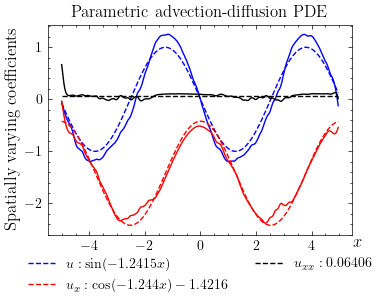

In [16]:
y1 = sin(x * -1.2415)
y2 = cos(-1.2439959 * x) - 1.4215299
y3 = 0.064058535*np.ones(len(x))
fs = 12
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(x, f_u, '-', c='blue')
    ax.plot(x, y1, '--', c='blue', label='$u: \sin(-1.2415x)$')
    ax.plot(x, f_u_x, '-', c='red')
    ax.plot(x, y2, '--', c='red', label='$u_{x}: \cos(-1.244x)-1.4216$')
    ax.plot(x, f_u_xx, '-', c='black')
    ax.plot(x, y3, '--', c='black', label='$u_{xx}: 0.06406$')
    ax.set_ylabel('Spatially varying coefficients', fontsize=fs)
    ax.set_xlabel('$x$', fontsize=fs)
    ax.xaxis.set_label_coords(1.02, 0)
    ax.set_title("Parametric advection-diffusion PDE", fontsize=fs)
    ax.legend(fontsize=fs)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=False, shadow=False, ncol=2)
    fig.tight_layout()
    plt.savefig(f"/Users/pongpisit/Documents/latex/UBIC-ACML/figures/ad_vc_noise{noise_lv}.pdf")
    plt.show()

In [17]:
# propose
# significant testing (จำนวนกลุ่มตัวอย่างที่สุ่มออกมาเท่ากับ len(x) or len(t)) 
# + BIC in peridogram (& weak-form space for ordinary PDEs)
# note: epsilon = 1e-5
# metric learning not sure ... (optional)
# target PDEs Parametric Burgers, AD, KS + (Burgers&KS for ordinary PDEs)